**Declare packages:**

In [2]:
import warnings

warnings.filterwarnings("ignore")

## Data
import pandas as pd
import numpy as np

## Plots
import matplotlib.pyplot as plt
import seaborn as sns

## Machine learning
from sklearn import metrics, preprocessing

## Deep learning
from tensorflow import config
from keras import models, layers, utils

**Import WikiArt dataset:**

In [3]:
# WikiArt
wiki_art_set = pd.read_csv("datasets/wiki_art.csv")

wiki_art_set = wiki_art_set[~wiki_art_set["class_name"].isna()]
wiki_art_set["art_id"] = range(0, len(wiki_art_set))
wiki_art_set["genre"] = wiki_art_set["class_name"]
wiki_art_set = wiki_art_set.drop(["class_name", "labels"], axis='columns')

wiki_art_set

,image_path,art_id,genre
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,0,genre-painting
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,1,genre-painting
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,2,genre-painting
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,3,genre-painting
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,4,genre-painting
...,...,...,...
96009,/kaggle/input/wikiart-gangogh-creating-art-gan...,96009,landscape
96010,/kaggle/input/wikiart-gangogh-creating-art-gan...,96010,landscape
96011,/kaggle/input/wikiart-gangogh-creating-art-gan...,96011,landscape
96012,/kaggle/input/wikiart-gangogh-creating-art-gan...,96012,landscape


**Import Users dataset:**

In [4]:
# Users
users_set = pd.read_csv("datasets/users.csv")

users_set["genres"] = users_set.apply(lambda row: set([row["genre_1"], row["genre_2"], row["genre_3"]]), axis=1)
users_set["user_id"] = range(0, len(users_set))
users_set = users_set.drop(["id", "genre_1", "genre_2", "genre_3"], axis='columns')

users_set

,first_name,last_name,gender,favorite_color_hex,age,genres,user_id
0,Inglebert,McKerton,Male,#6d2c6f,16,"{still-life, landscape, animal-painting}",0
1,Spike,Hanhardt,Male,#d49fd1,53,"{abstract, landscape, cityscape}",1
2,Muhammad,Hasely,Male,#f6de77,60,"{portrait, nude-painting-nu, mythological-pain...",2
3,Kaleb,Verring,Male,#db2552,50,"{abstract, still-life, mythological-painting}",3
4,Donovan,Dethloff,Genderqueer,#d14bad,38,"{landscape, mythological-painting}",4
...,...,...,...,...,...,...,...
995,Del,Bycraft,Male,#988aaa,54,"{animal-painting, marina}",995
996,Ofilia,Hasted,Female,#8edfc5,32,"{abstract, landscape, figurative}",996
997,Haley,People,Female,#a5c0fa,54,"{abstract, nude-painting-nu}",997
998,Charlena,Lipprose,Female,#4d5f42,34,"{still-life, landscape, symbolic-painting}",998


**Rating dataset:**

In [5]:
ratings_set = pd.read_csv("datasets/ratings.csv")

ratings_set = ratings_set.merge(wiki_art_set[["art_id", "image_path"]], how="left")
ratings_set = ratings_set.rename(columns={"explicit_rating": "y"})
ratings_set["user_id"] = ratings_set["user_id"].apply(lambda x: x - 1)

ratings_set

,user_id,art_id,y,watched_to_the_end,liked,image_path
0,0,41354,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
1,0,1395,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
2,0,86062,5.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
3,0,32920,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
4,0,8807,6.0,True,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
...,...,...,...,...,...,...
14491,999,41518,7.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
14492,999,46329,5.0,False,False,/kaggle/input/wikiart-gangogh-creating-art-gan...
14493,999,94235,9.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...
14494,999,60828,7.0,False,True,/kaggle/input/wikiart-gangogh-creating-art-gan...


**Extract context:**

In [6]:
context_set = ratings_set[["user_id", "art_id", "y", "watched_to_the_end", "liked"]]

context_set.head()

,user_id,art_id,y,watched_to_the_end,liked
0,0,41354,6.0,True,True
1,0,1395,6.0,True,True
2,0,86062,5.0,True,True
3,0,32920,6.0,True,True
4,0,8807,6.0,True,True


**Analyzing data:**

In [7]:
tags = wiki_art_set["genre"].unique()

print(tags)

['genre-painting' 'symbolic-painting' 'nude-painting-nu' 'flower-painting'
 'animal-painting' 'religious-painting' 'figurative' 'marina' 'abstract'
 'still-life' 'portrait' 'cityscape' 'mythological-painting' 'landscape']


In [8]:
for tag in tags:
    wiki_art_set[tag] = wiki_art_set["genre"].apply(lambda x: 1 if tag in x else 0)
wiki_art_set.head()

,image_path,art_id,genre,genre-painting,symbolic-painting,nude-painting-nu,flower-painting,animal-painting,religious-painting,figurative,marina,abstract,still-life,portrait,cityscape,mythological-painting,landscape
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,0,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,1,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,2,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,3,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,4,genre-painting,1,0,0,0,0,0,0,0,0,0,0,0,0,0


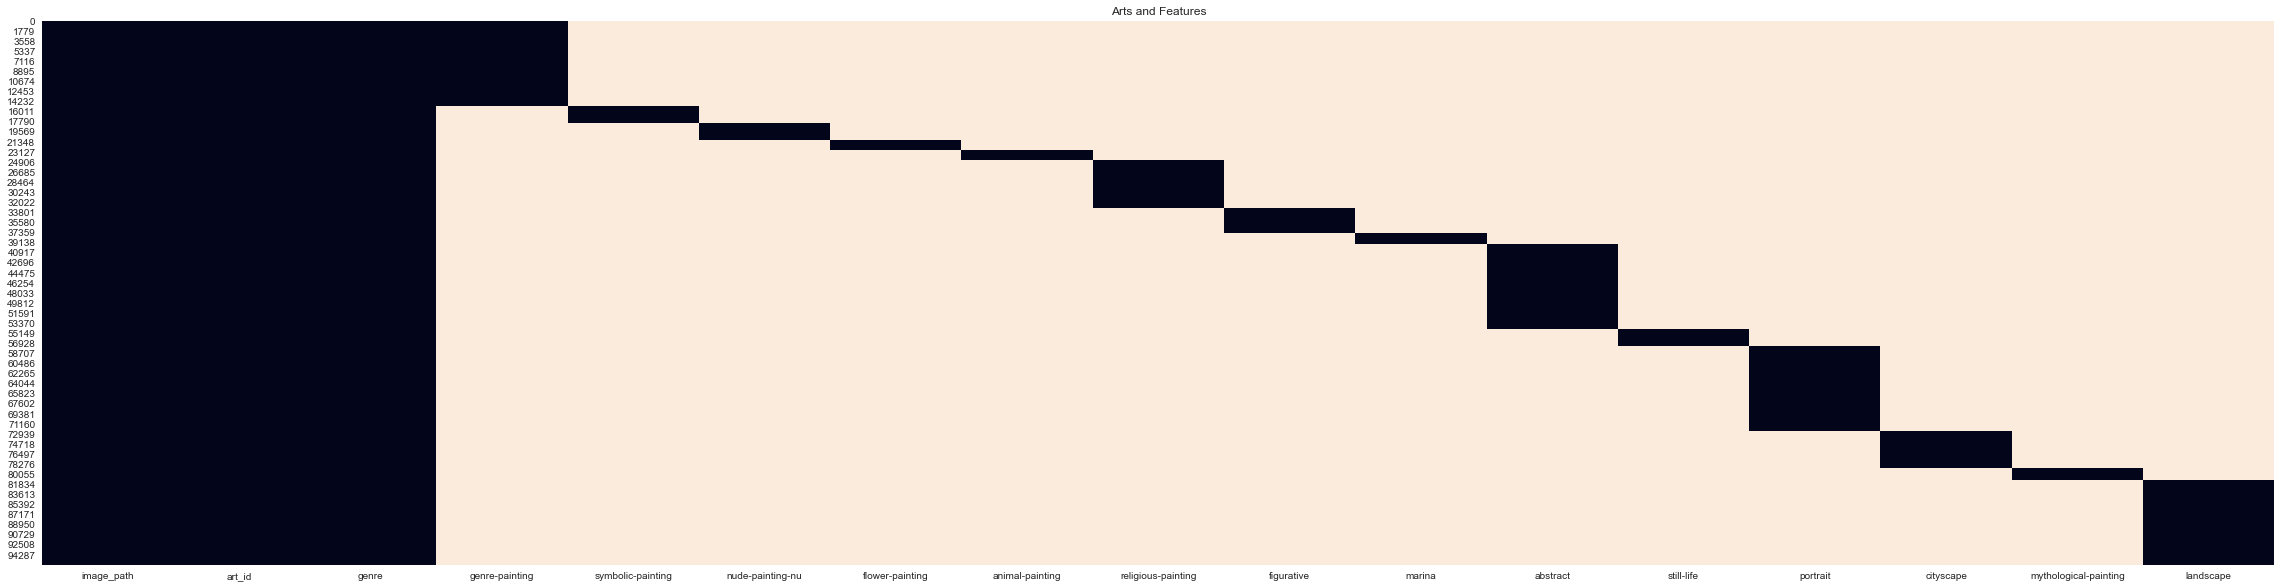

In [9]:
plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(40, 10))

sns.heatmap(wiki_art_set == 0, vmin=0, vmax=1, cbar=False, ax=ax).set_title("Arts and Features")

plt.show()

**Users and ratings:**

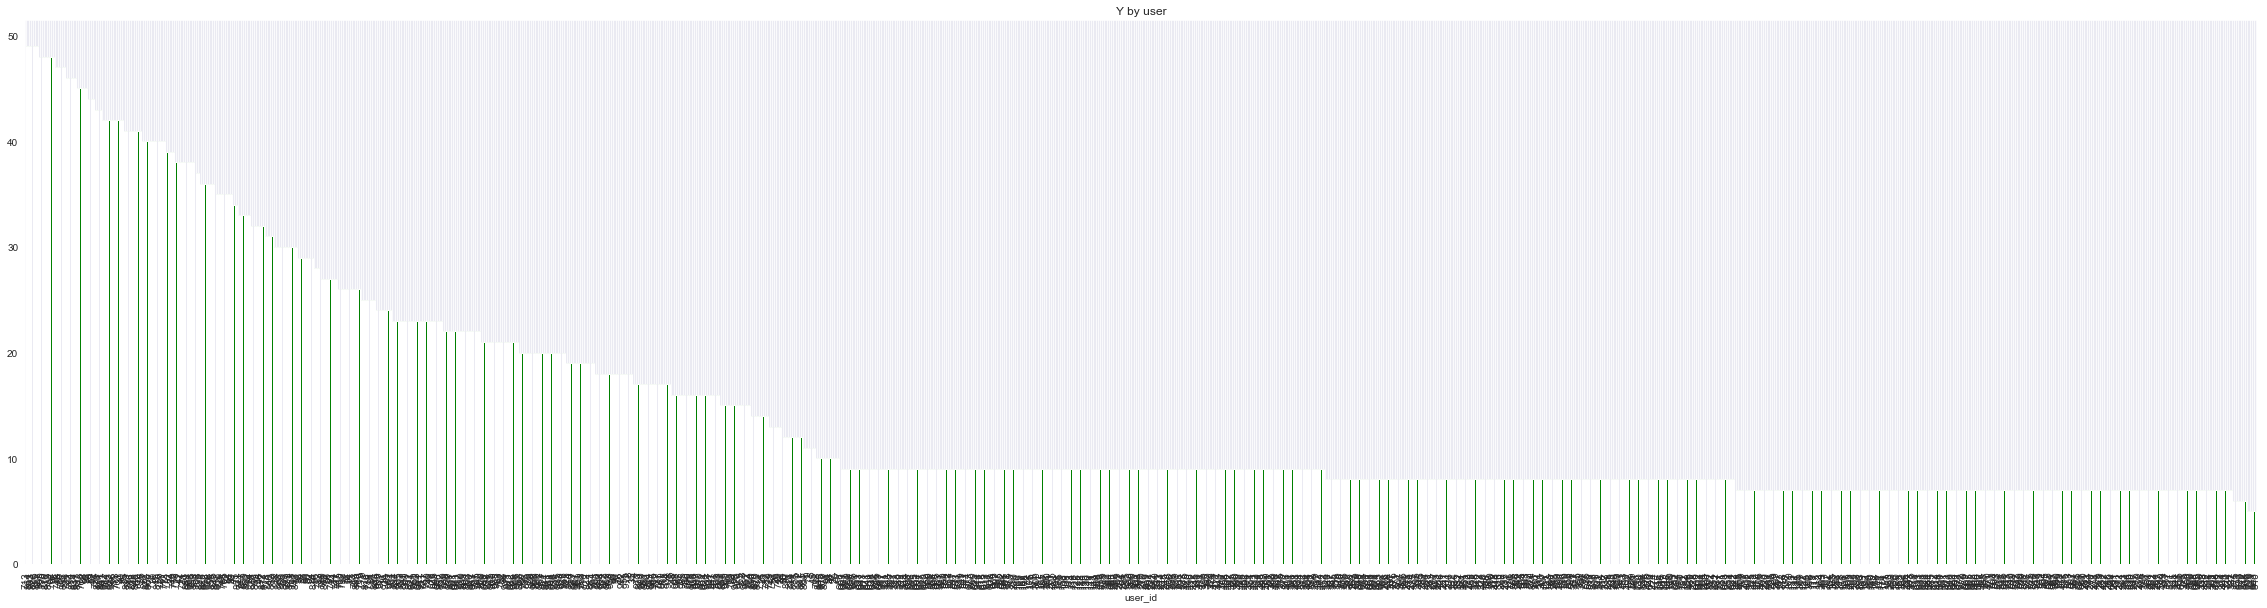

In [10]:
ratings_set.groupby("user_id").count()["art_id"].sort_values(ascending=False).plot(
    kind="bar", color="green", title="Y by user", figsize=(40, 10)).grid(axis='y')

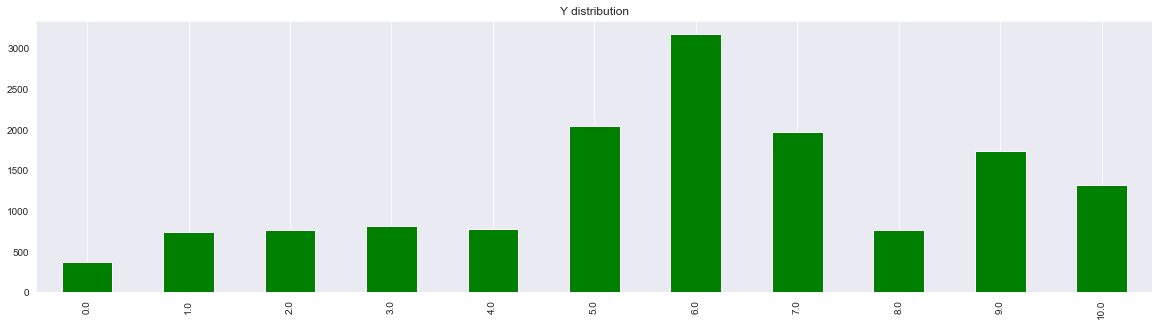

In [11]:
ratings_set["y"].value_counts().sort_index().plot(kind="bar", color="green", title="Y distribution",
                                                  figsize=(20, 5)).grid(axis='y')
plt.show()

In [12]:
tmp = ratings_set.copy()

ratings_set = tmp.pivot_table(index="user_id", columns="art_id", values="y")

missing_columns = list(set(wiki_art_set.index) - set(ratings_set.columns))

for column in missing_columns:
    ratings_set[column] = np.nan
ratings_set = ratings_set[sorted(ratings_set.columns)]

ratings_set

art_id,0,1,2,3,4,5,6,7,8,9,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


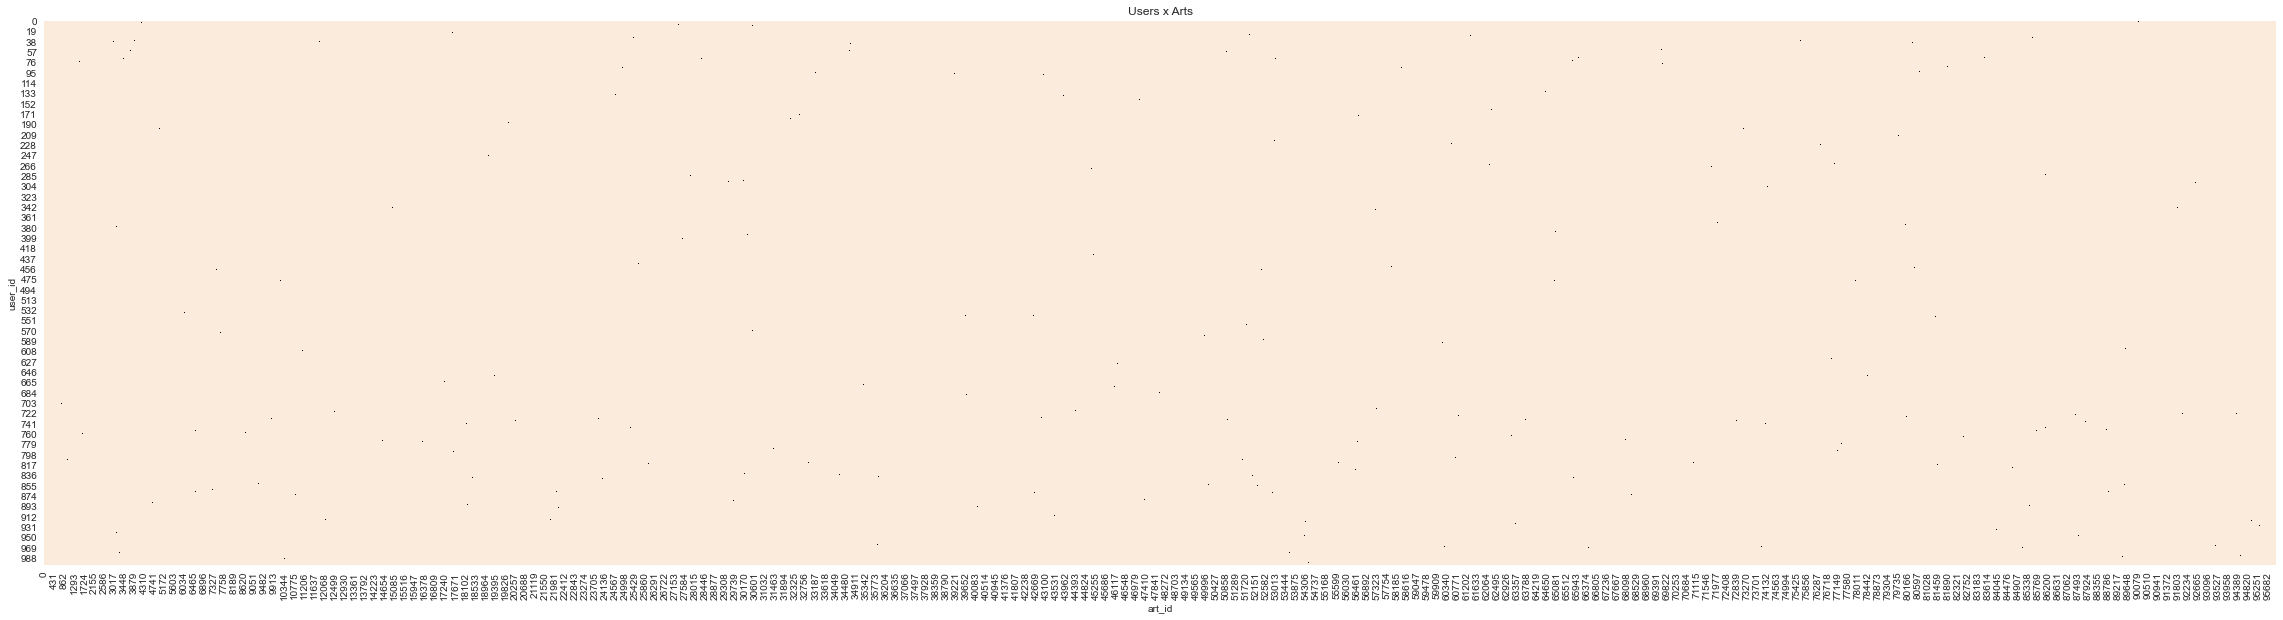

In [13]:
fig, ax = plt.subplots(figsize=(40, 10))
sns.heatmap(ratings_set.isnull(), vmin=0, vmax=1, cbar=False, ax=ax).set_title("Users x Arts")
plt.show()

**Context:**

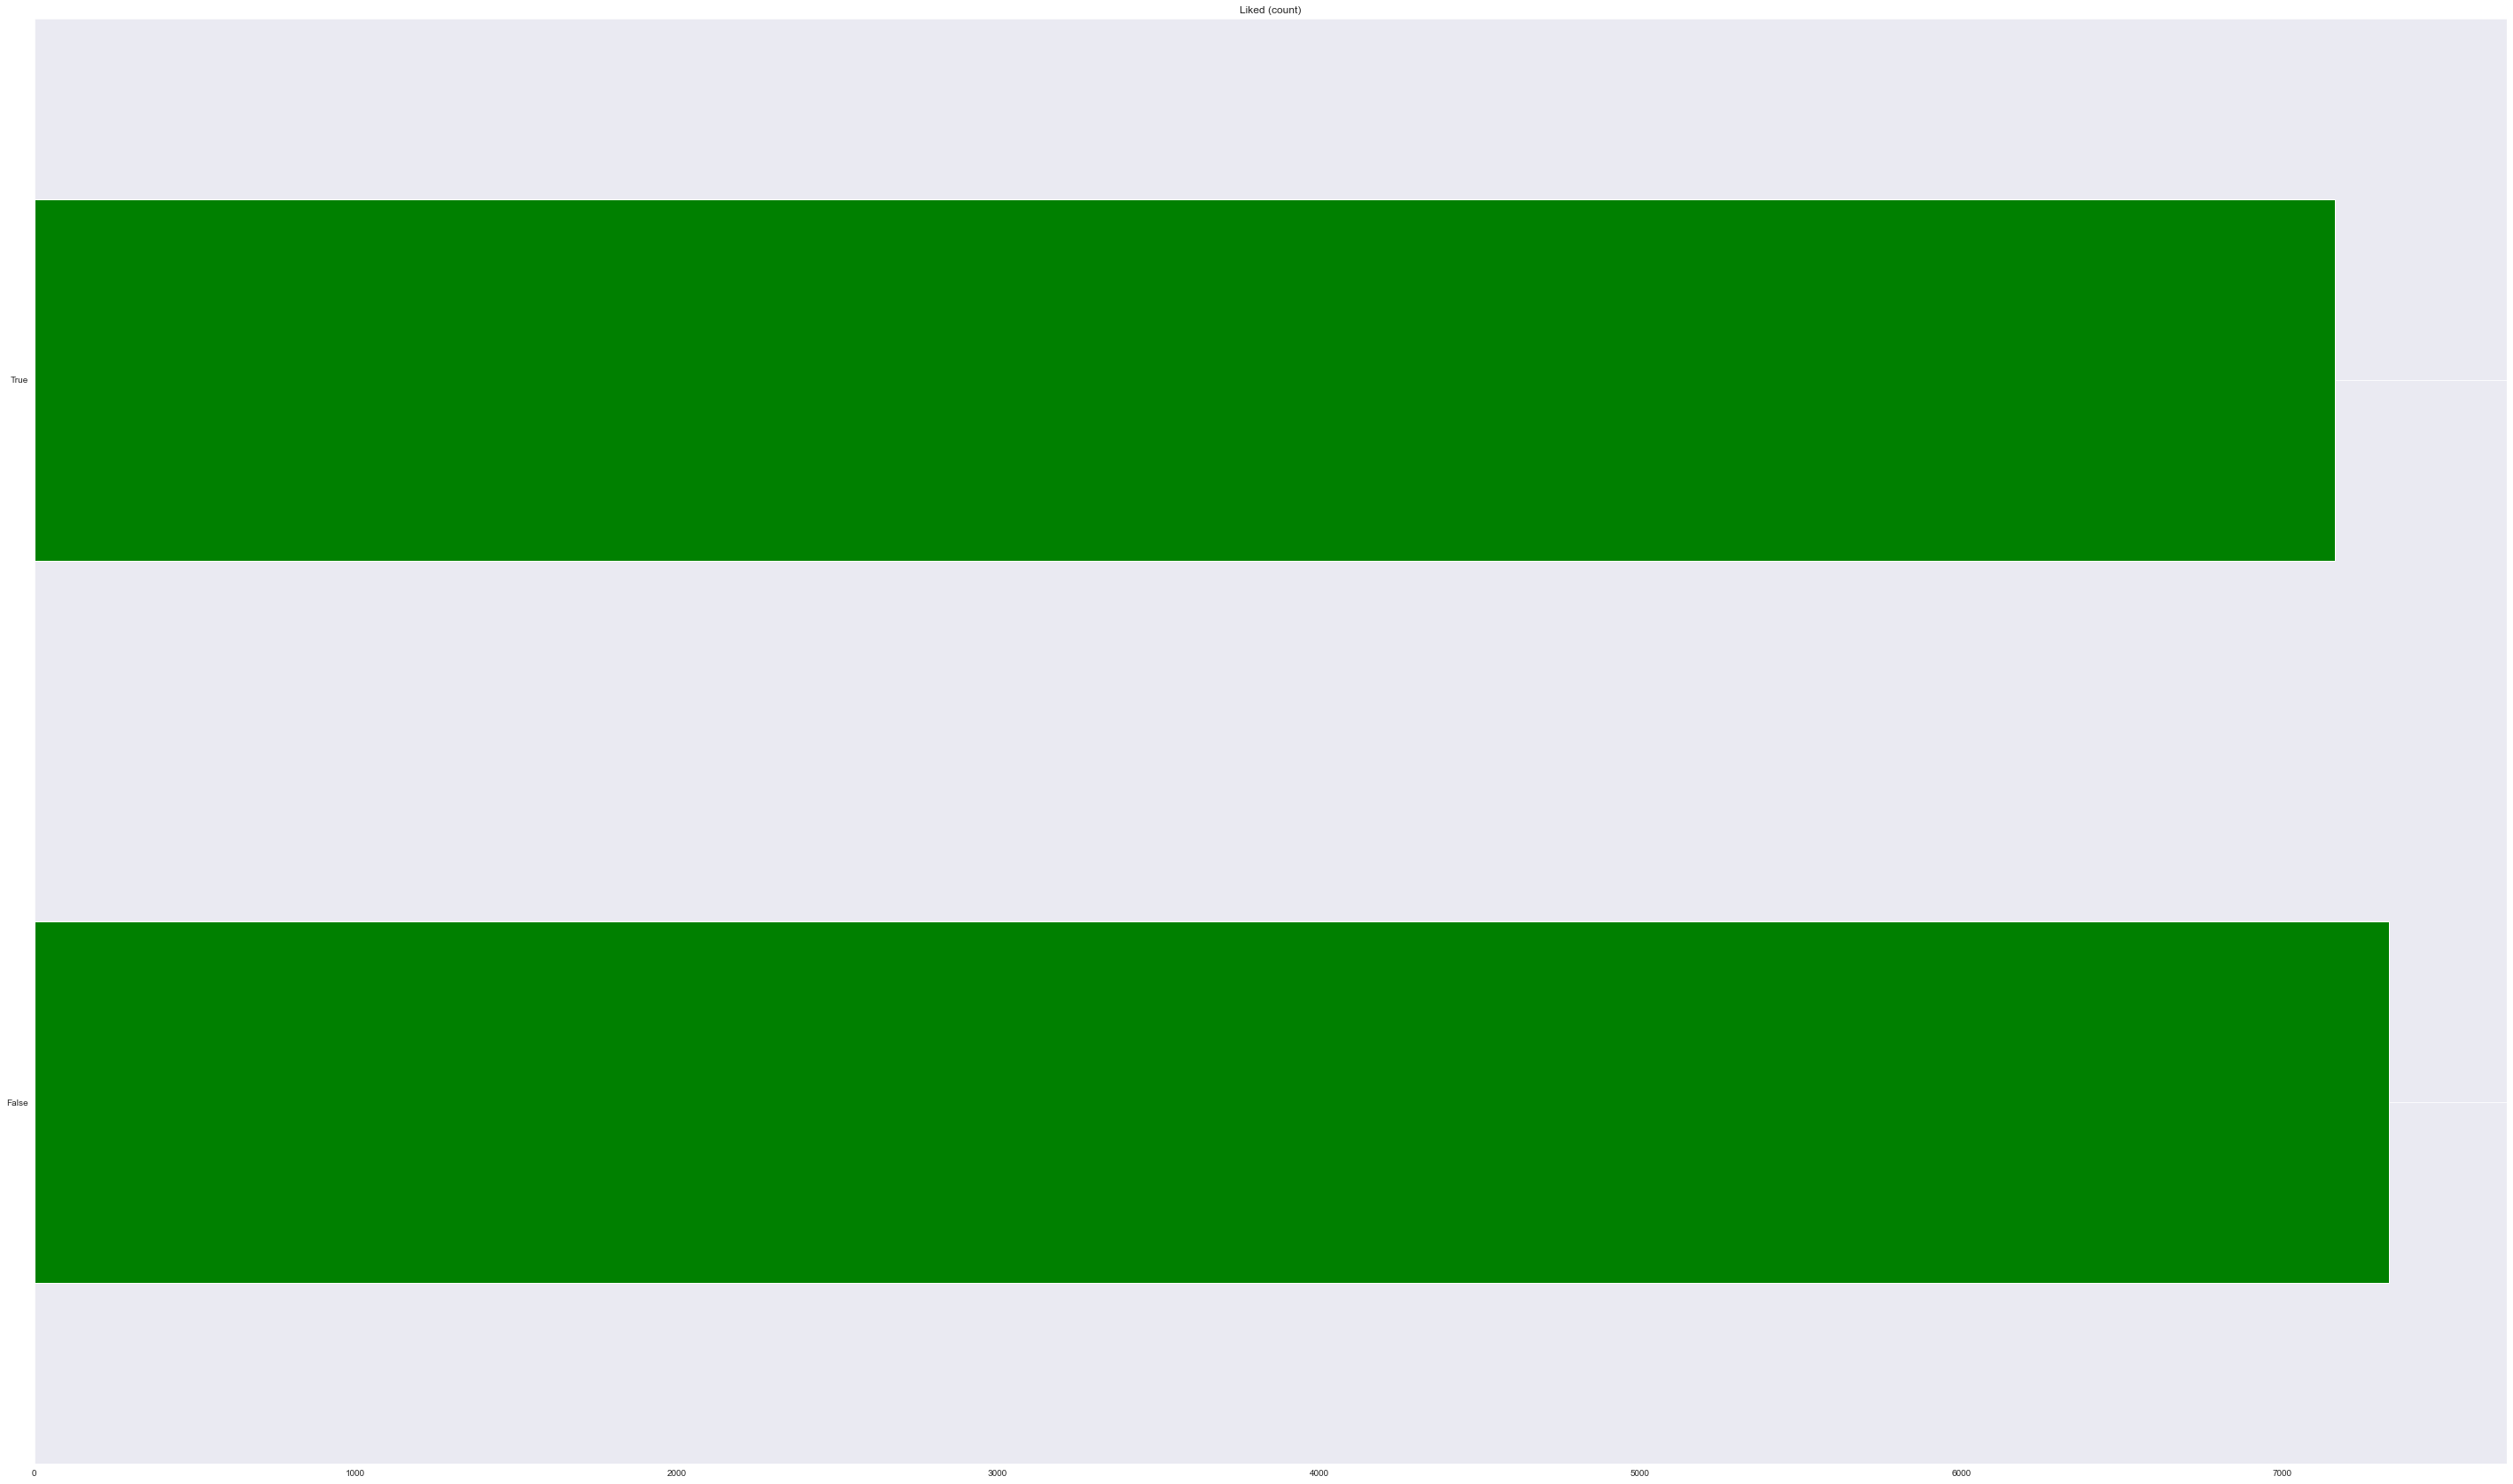

In [14]:
context_set["liked"].value_counts().plot(kind="barh", color="green", title="Liked (count)",
                                         figsize=(50, 30)).grid(axis='x')
plt.show()

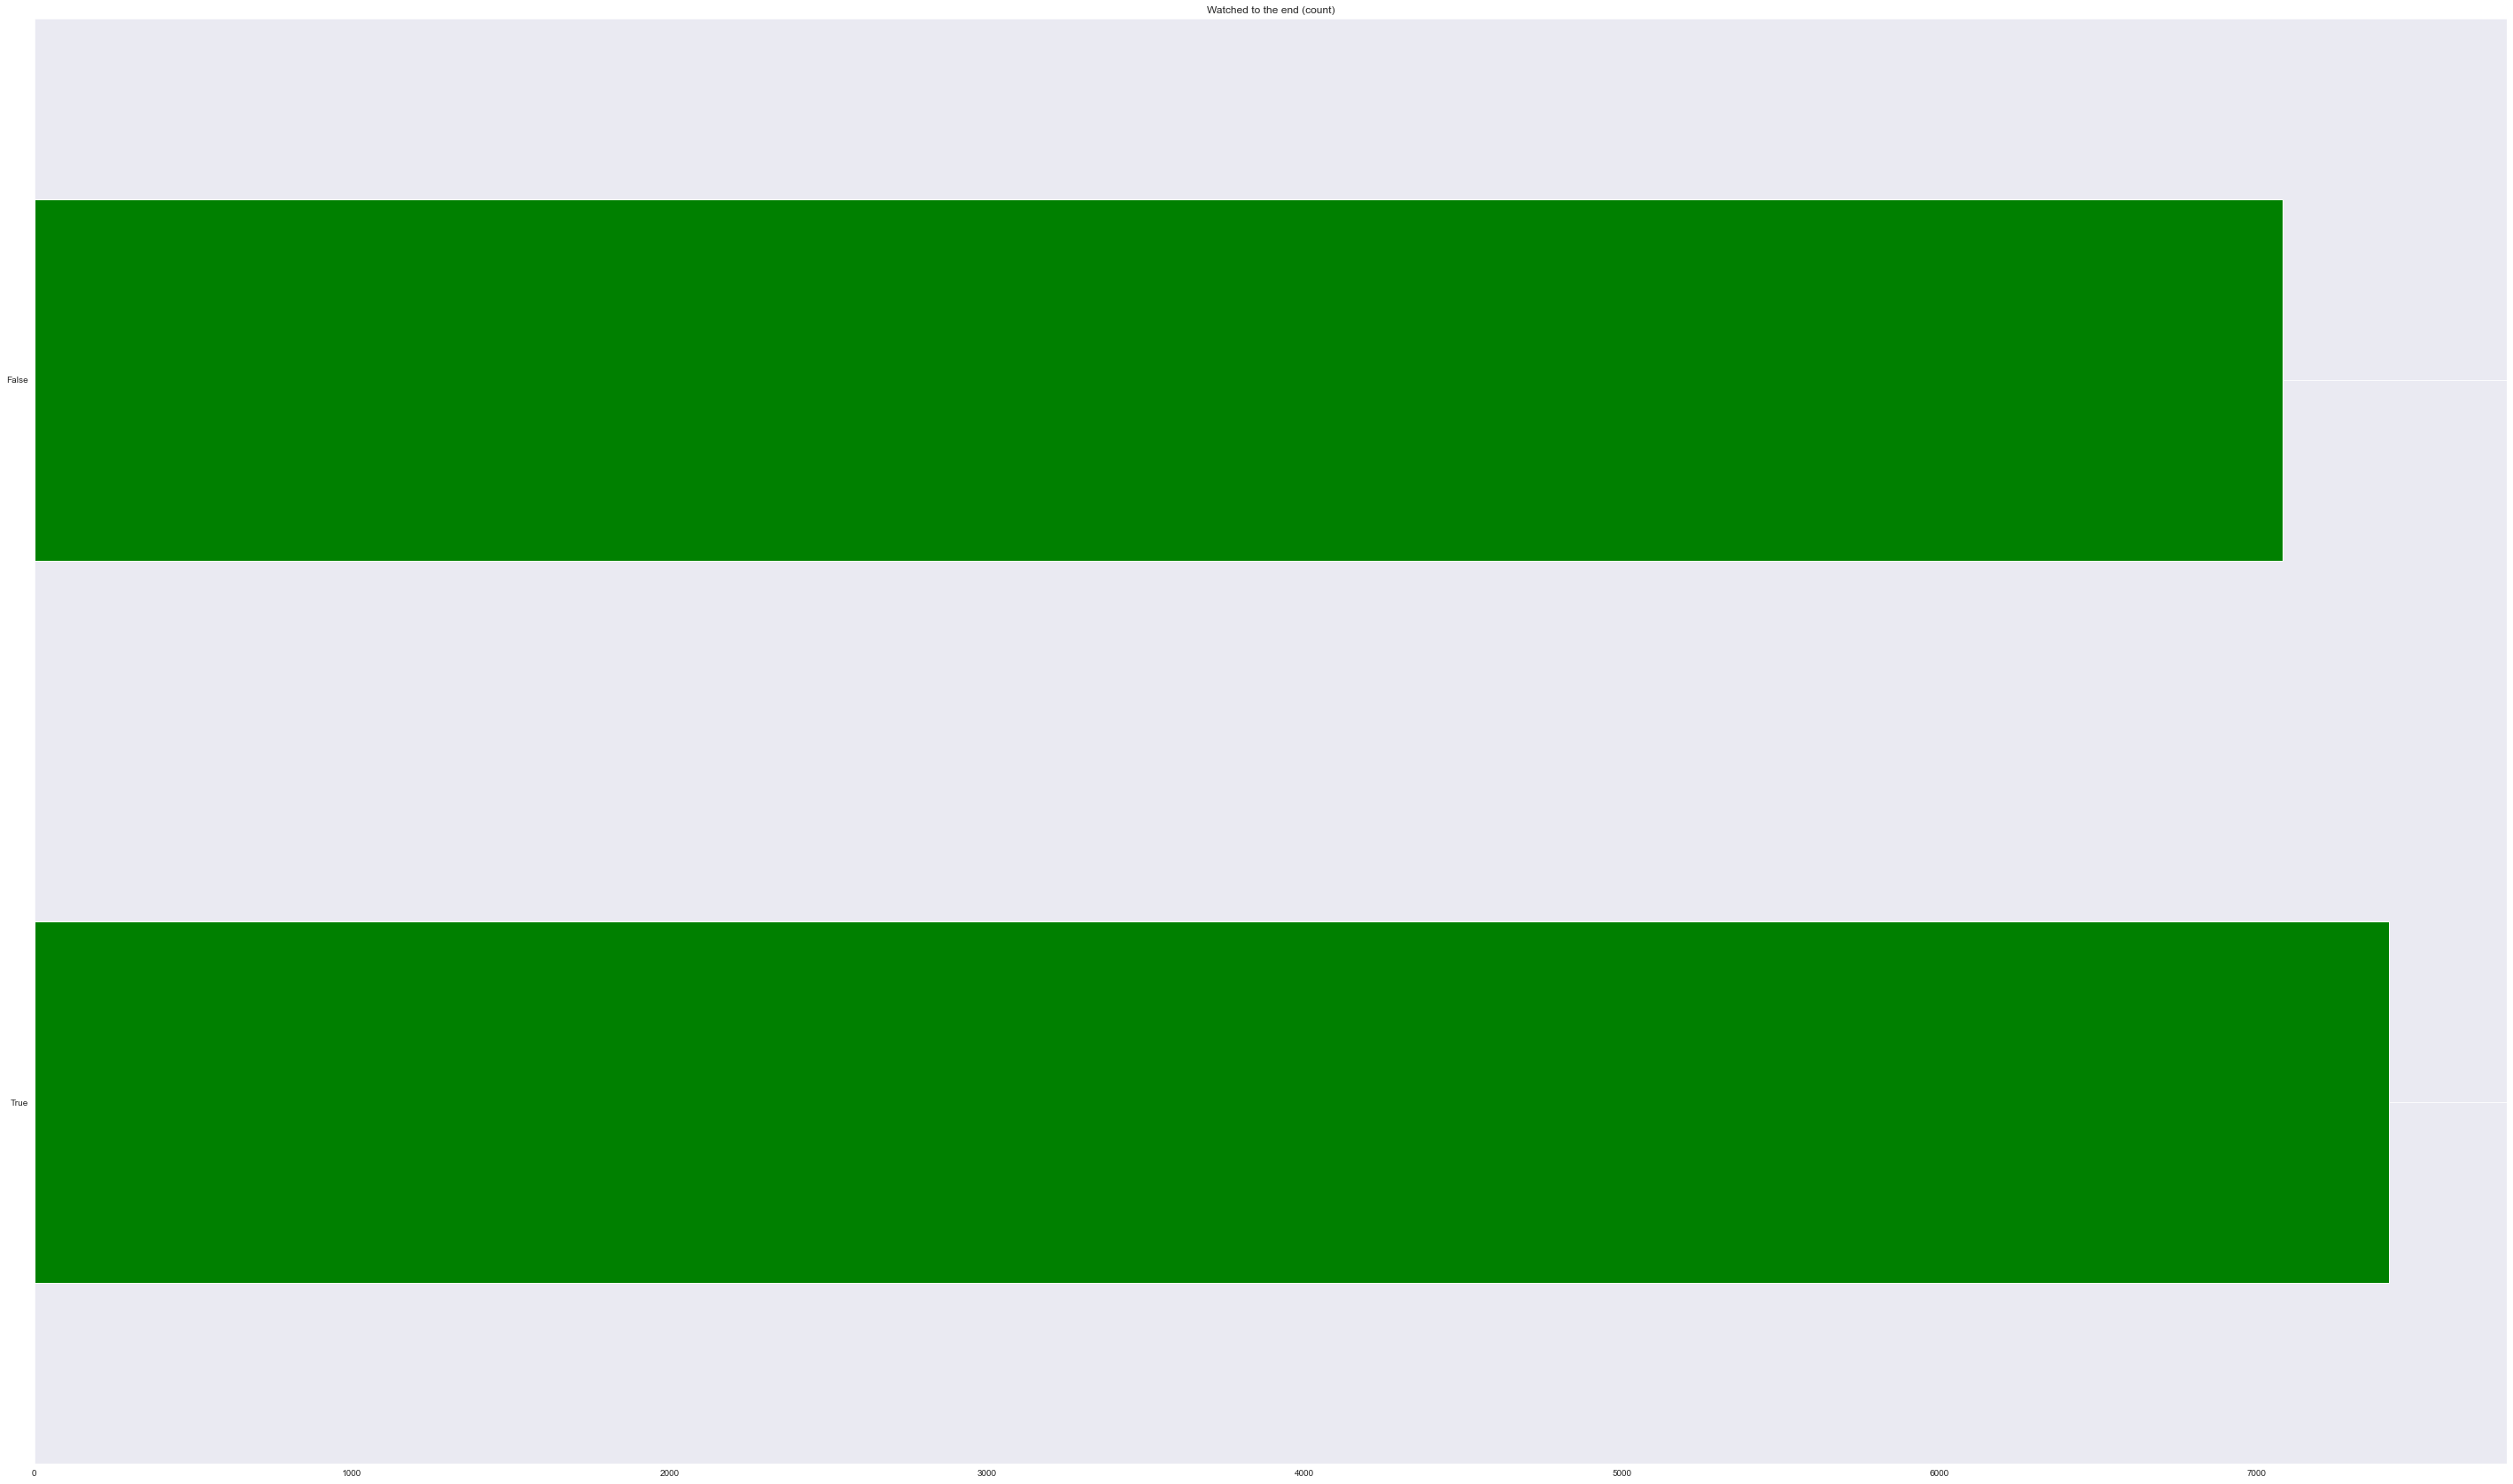

In [15]:
context_set["watched_to_the_end"].value_counts().plot(kind="barh", color="green", title="Watched to the end (count)",
                                                      figsize=(50, 30)).grid(axis='x')
plt.show()

**Preprocessing**
Scaling:

In [16]:
ratings_set = pd.DataFrame(preprocessing.MinMaxScaler(feature_range=(0.5, 1)).fit_transform(ratings_set.values),
                           columns=ratings_set.columns, index=ratings_set.index)
ratings_set

art_id,0,1,2,3,4,5,6,7,8,9,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Partitioning:

In [17]:
split = int(0.8 * ratings_set.shape[1])
split

76811

Train:

In [18]:
train_set = ratings_set.loc[:, :split - 1]

print("non-null data:", train_set[train_set > 0].count().sum())

train_set

non-null data: 11659


art_id,0,1,2,3,4,5,6,7,8,9,...,76801,76802,76803,76804,76805,76806,76807,76808,76809,76810
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Test:

In [19]:
test_set = ratings_set.loc[:, split:]

print("non-null data:", test_set[test_set > 0].count().sum())

test_set

non-null data: 2837


art_id,76811,76812,76813,76814,76815,76816,76817,76818,76819,76820,...,96004,96005,96006,96007,96008,96009,96010,96011,96012,96013
user_id,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Baseline (Content-Based)**
Select a user:

In [20]:
# i = 1
#
# train = train_set.iloc[i].to_frame(name="y")
# test = test_set.iloc[i].to_frame(name="y")
#
# print("train:", len(train[~train["y"].isna()]), "| test:", len(test[~test["y"].isna()]))
#
# test.head()

Add all arts in test as empty:

In [21]:
# tmp = test.copy()
# tmp["y"] = np.nan
#
# train = train.append(tmp)
#
# train.tail()

Create Model:

In [22]:
# usr = train[["y"]].fillna(0).values.T
#
# prd = wiki_art_set.drop(["image_path", "genre"], axis=1).values
#
# print("Users", usr.shape, " x  Arts", prd.shape)

In [23]:
# ## usr_ft(users,features) = usr(users,arts) x prd(arts,features)
# usr_ft = np.dot(usr, prd)
# ## normalize
# weights = usr_ft / usr_ft.sum()
# ## predicted rating(users,arts) = weights(users,features) x prd.T(features,arts)
# prediction = np.dot(weights, prd.T)
#
# test = test.merge(pd.DataFrame(prediction[0], columns=["yhat"]), how="left", left_index=True,
#                   right_index=True).reset_index()
#
# test = test[~test["y"].isna()]
#
# test

Evaluate:

In [24]:
def mean_reciprocal_rank(y_test, predicted):
    score = []
    for art in y_test:
        mrr = 1 / (list(predicted).index(art) + 1) if art in predicted else 0
        score.append(mrr)
    return np.mean(score)

#
#
# print("--- user", i, "---")
#
# top = 5
# y_test = test.sort_values("y", ascending=False)["art_id"].values[:top]
# print("y_test:", y_test)
#
# predicted = test.sort_values("yhat", ascending=False)["art_id"].values[:top]
# print("predicted:", predicted)
#
# true_positive = len(list(set(y_test) & set(predicted)))
# print("true positive:", true_positive, "(" + str(round(true_positive / top * 100, 1)) + "%)")
# print("accuracy:", str(round(metrics.accuracy_score(y_test, predicted) * 100, 1)) + "%")
# print("mrr:", round(mean_reciprocal_rank(y_test, predicted), 2))

In [25]:
# test.merge(
#     wiki_art_set[["image_path", "art_id", "genre"]], left_on="art_id", right_index=True
# ).sort_values("yhat", ascending=False)

**Model implementation & testing:**

In [26]:
# train = train_set.stack(dropna=True).reset_index().rename(columns={0: "y"})
# train.head()

In [27]:
# test = test_set.stack(dropna=True).reset_index().rename(columns={0: "y"})
# test.head()

Model:

In [28]:
# embeddings_size = 50
# usr, prd = ratings_set.shape[0], ratings_set.shape[1]
#
# # Users (,1,embedding_size) and Reshape (,embedding_size)
# xusers_in = layers.Input(name="xusers_in", shape=(1,))
# xusers_emb = layers.Embedding(name="xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
# xusers = layers.Reshape(name='xusers', target_shape=(embeddings_size,))(xusers_emb)
#
# # Arts (,1,embedding_size) and Reshape (,embedding_size)
# xarts_in = layers.Input(name="xarts_in", shape=(1,))
# xarts_emb = layers.Embedding(name="xarts_emb", input_dim=prd, output_dim=embeddings_size)(xarts_in)
# xarts = layers.Reshape(name='xarts', target_shape=(embeddings_size,))(xarts_emb)
#
# # Art (,1) values[-1,1]
# xx = layers.Dot(name='xx', normalize=True, axes=1)([xusers, xarts])
#
# # Predict ratings (,1)
# y_out = layers.Dense(name="y_out", units=1, activation='linear')(xx)
#
# # Compile
# model = models.Model(inputs=[xusers_in, xarts_in], outputs=y_out, name="CollaborativeFiltering")
# model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
# model.summary()

In [29]:
# utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

Train and test:

In [30]:
'''
Plot loss and metrics of keras training.
'''


def utils_plot_keras_training(training):
    metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
    fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15, 3))

    ## training
    ax[0].set(title="Training")
    ax11 = ax[0].twinx()
    ax[0].plot(training.history['loss'], color='black')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax11.plot(training.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
    ax11.legend()

    ## validation
    ax[1].set(title="Validation")
    ax22 = ax[1].twinx()
    ax[1].plot(training.history['val_loss'], color='black')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss', color='black')
    for metric in metrics:
        ax22.plot(training.history['val_' + metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
    plt.show()

In [31]:
# # train
# training = model.fit(x=[train["user_id"], train["art_id"]], y=train["y"],
#                      epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)
# model = training.model
# utils_plot_keras_training(training)

In [32]:
# # test
# test["yhat"] = model.predict([test["user_id"], test["art_id"]])
# test

Evaluate

In [33]:
# # overall
# y_test = test["y"]
# predicted = test["yhat"]
#
# print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
# print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
#       str(round(np.mean(np.abs((y_test - predicted) / predicted)), 2)) + "%")

In [34]:
# # single case
# i = 1
# print("--- user", i, "---")
#
# top = 5
# y_test = test[test["user_id"] == i].sort_values("y", ascending=False)["art_id"].values[:top]
# print("y_test:", y_test)
#
# predicted = test[test["user_id"] == i].sort_values("yhat", ascending=False)["art_id"].values[:top]
# print("predicted:", predicted)
#
# true_positive = len(list(set(y_test) & set(predicted)))
# print("true positive:", true_positive, "(" + str(round(true_positive / top * 100, 1)) + "%)")
# print("accuracy:", str(round(metrics.accuracy_score(y_test, predicted) * 100, 1)) + "%")
# print("mrr:", round(mean_reciprocal_rank(y_test, predicted), 2))

In [35]:
# test[test["user_id"] == i].merge(
#     wiki_art_set[["image_path", "art_id", "genre"]], left_on="art_id", right_index=True
# ).sort_values("yhat", ascending=False)

HYBRID RECOMMENDER

In [36]:
# Extra data
features = wiki_art_set.drop(["image_path"], axis=1).columns
print(features)

context = context_set.drop(["user_id", "art_id"], axis=1).columns
print(context)

Index(['art_id', 'genre', 'genre-painting', 'symbolic-painting',
       'nude-painting-nu', 'flower-painting', 'animal-painting',
       'religious-painting', 'figurative', 'marina', 'abstract', 'still-life',
       'portrait', 'cityscape', 'mythological-painting', 'landscape'],
      dtype='object')
Index(['y', 'watched_to_the_end', 'liked'], dtype='object')


In [51]:
train = train_set.stack(dropna=True).reset_index().rename(columns={0: "y"})

## add features
train = train.merge(wiki_art_set[features], how="left", left_on="art_id", right_index=True)

## add context
train = train.merge(context_set, how="left")

train.head()

,user_id,art_id_x,y,art_id_y,genre,genre-painting,symbolic-painting,nude-painting-nu,flower-painting,animal-painting,...,marina,abstract,still-life,portrait,cityscape,mythological-painting,landscape,art_id,watched_to_the_end,liked
0,0,1395,0.5,1395,genre-painting,1,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,0,8807,1.0,8807,genre-painting,1,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,0,16365,0.5,16365,symbolic-painting,0,1,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
3,0,21474,0.5,21474,flower-painting,0,0,0,1,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,0,32920,0.5,32920,religious-painting,0,0,0,0,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN


In [52]:
test = test_set.stack(dropna=True).reset_index().rename(columns={0: "y"})

## add features
test = test.merge(wiki_art_set.drop(["image_path"], axis=1), how="left", left_on="art_id", right_index=True)

## add context
test[context] = 0  #--> simulate production for a weekday night
#test = test.merge(dtf_context, how="left") #--> use test set

test.head()

,user_id,art_id_x,y,art_id_y,genre,genre-painting,symbolic-painting,nude-painting-nu,flower-painting,animal-painting,...,figurative,marina,abstract,still-life,portrait,cityscape,mythological-painting,landscape,watched_to_the_end,liked
0,0,80311,0,80311,mythological-painting,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,86062,0,86062,landscape,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,89643,0,89643,landscape,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,90095,0,90095,landscape,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,92178,0,92178,landscape,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Model Design

In [59]:
embeddings_size = 50

usr, prd = ratings_set.shape[0], ratings_set.shape[1]

feat = len(features)
ctx = len(context)

########################################## COLLABORATIVE FILTERING ###################################################
# Input layer
xusers_in = layers.Input(name="xusers_in", shape=(1,))
xarts_in = layers.Input(name="xarts_in", shape=(1,))

# A) Matrix Factorization
## embeddings and reshape
cf_xusers_emb = layers.Embedding(name="cf_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
cf_xusers = layers.Reshape(name='cf_xusers', target_shape=(embeddings_size,))(cf_xusers_emb)

## embeddings and reshape
cf_xarts_emb = layers.Embedding(name="cf_xarts_emb", input_dim=prd, output_dim=embeddings_size)(xarts_in)
cf_xarts = layers.Reshape(name='cf_xarts', target_shape=(embeddings_size,))(cf_xarts_emb)

## art
cf_xx = layers.Dot(name='cf_xx', normalize=True, axes=1)([cf_xusers, cf_xarts])

# B) Neural Network
## embeddings and reshape
nn_xusers_emb = layers.Embedding(name="nn_xusers_emb", input_dim=usr, output_dim=embeddings_size)(xusers_in)
nn_xusers = layers.Reshape(name='nn_xusers', target_shape=(embeddings_size,))(nn_xusers_emb)

## embeddings and reshape
nn_xarts_emb = layers.Embedding(name="nn_xarts_emb", input_dim=prd, output_dim=embeddings_size)(xarts_in)
nn_xarts = layers.Reshape(name='nn_xarts', target_shape=(embeddings_size,))(nn_xarts_emb)

## concat and dense
nn_xx = layers.Concatenate()([nn_xusers, nn_xarts])
nn_xx = layers.Dense(name="nn_xx", units=int(embeddings_size / 2), activation='relu')(nn_xx)

########################################## CONTENT BASED ###################################################
# Art Features
features_in = layers.Input(name="features_in", shape=(feat,))
features_x = layers.Dense(name="features_x", units=feat, activation='relu')(features_in)

########################################## OUTPUT ###################################################
# Merge all
y_out = layers.Concatenate()([cf_xx, nn_xx, features_x])
y_out = layers.Dense(name="y_out", units=1, activation='linear')(y_out)

# Compile
model = models.Model(inputs=[xusers_in, xarts_in, features_in], outputs=y_out, name="Hybrid_Model")
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])
model.summary()

Model: "Hybrid_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 xusers_in (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 xarts_in (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 nn_xusers_emb (Embedding)      (None, 1, 50)        50000       ['xusers_in[0][0]']              
                                                                                                  
 nn_xarts_emb (Embedding)       (None, 1, 50)        4800700     ['xarts_in[0][0]']               
                                                                                       

In [60]:
utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


Train/Test

In [61]:
# train
training = model.fit(x=[train["user_id"], train["art_id"], train[features]], y=train["y"],
                     epochs=100, batch_size=128, shuffle=True, verbose=0, validation_split=0.3)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [62]:
model = training.model
utils_plot_keras_training(training)

NameError: name 'training' is not defined

In [63]:
# overall
y_test = test["y"]
predicted = test["yhat"]

print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, predicted)))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):",
      str(round(np.mean(np.abs((y_test - predicted) / predicted)), 2)) + "%")

KeyError: 'yhat'

In [64]:
# single case
i = 1
print("--- user", i, "---")

top = 5
y_test = test[test["user_id"] == i].sort_values("y", ascending=False)["art_id"].values[:top]
print("y_test:", y_test)

predicted = test[test["user_id"] == i].sort_values("yhat", ascending=False)["art_id"].values[:top]
print("predicted:", predicted)

true_positive = len(list(set(y_test) & set(predicted)))
print("true positive:", true_positive, "(" + str(round(true_positive / top * 100, 1)) + "%)")
print("accuracy:", str(round(metrics.accuracy_score(y_test, predicted) * 100, 1)) + "%")
print("mrr:", round(mean_reciprocal_rank(y_test, predicted), 2))

--- user 1 ---


KeyError: 'art_id'